<span style="color:gray;">Quantum Mechanics Review  + Practice w/Python  |  Chris Williams |   Jan 25, 2017 </span>
# Quantum Harmonic Oscillators and Resonant Tunneling Diodes

Applying the Hamiltonian Operator on a given wavefuntion, $\Psi$ results in the Schrodinger Equation,

$$ i\hbar  {\frac {\partial }{\partial t}}\Psi (\mathbf {r} ,t)={\hat {H}}\Psi (\mathbf {r} ,t) $$

for which solutions (to the time-independent Schrodinger eqn) exist for certan 'eigenenergies'. To visualize these eigenenergies and their corresponding eigenfunctions for a quantum harmonic oscillator, we must first construct the system in which the quantum mechanical particle will exist.


### Constructing a parabolic potential
To start, import required libraries and define the requred constants used to define potential energy of the system.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import plotly.plotly as py

from ipywidgets import *
from matplotlib import animation, rc
from IPython.display import HTML

hbar = 1.05e-14      #reduced planks constant in units of Å^2*kg/s
hbarSI = 1.055e-34   #"---------------------" in units of m^2*kg/s
m = 1.6266e-27       #mass of particle in units of kg
eV = 1.602e-19       #1 electron volt in units of J

#Define QHO potential parameters
omega = 5.6339e14
eta = 2
x_0 = np.sqrt(hbar/(m*omega))
a = 4*x_0 #width of potential in Å

# of finite difference steps
N = 100

#Create potential
x = np.linspace(-a,a,N)
V = 0.5*omega**2*m*np.power(abs(x),eta)

### Discretizing the 1D Hamiltonian
In order to solve the Schrodinger equation analytically we will discretize the Hamiltonian operator using a fintite-difference approximation. In matrix form, the discretized Hamiltonian can be written in the form

$$
{\mathbf  {\hat{H}}}={\frac  {\hbar ^{2}}{2m}}{\frac  {d^{2}}{dx^{2}}}+V(x)={\begin{pmatrix}\ldots &-t&0&0&0\\-t&V_{{-1}}+2t&-t&0&0\\0&-t&V_{0}+2t&-t&0\\0&0&-t&V_{1}+2t&-t\\0&0&0&-t&\ldots \\\end{pmatrix}}
$$

where $V(x)$ is the potential energy of the system and $t\equiv {\frac  {\hbar ^{2}}{2ma^{2}}}$. Because the Hamiltonian is the operator associated with the total energy of the system, applying the Hamiltonian to a wavefunction creates an eigenvalue problem that we can solve to determine the eigenenergies & eigenfunctions associated with the system we've constructed.

In [2]:
dx = 2*a/N

#Create tridiagonal Laplacian for Hamiltonian (TODO: use diag insead?)
def hamiltonian(N, V):
    
    U = np.zeros((N,N))
    
    
    for i in range(0,N):
        U[i,i]= -2
        if i > 0:
            U[i, i-1] = 1
        if i < N-1:
            U[i,i+1] = 1

    #Compute Hamiltonian and solve eigenvalue problem
    return -(hbar**2/(2*m))*U/dx**2 + np.diag(V)

E,v = np.linalg.eigh(hamiltonian(N, V))

With the eigenvalue problem solved we can visualize the eigenfunctions of the quantum harmonic oscillator we've constructed for a few of the low-energy eigenstates. The QHO is a good approximation of simple chemical bonds (see original pdf). Note that the absolute magnitudes of the position/energy are not meaningfully normalized.

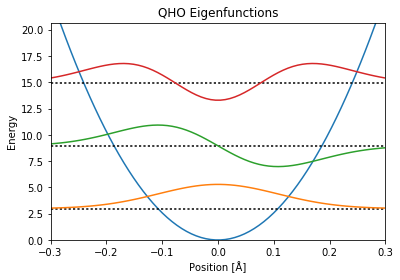

In [3]:
#Plot QHO potential
plt.plot(x,V)

plt.ylim([0,1.25*np.max(v[:,2]/np.sqrt(dx)+E[2])])
plt.xlim([-.3,.3])
plt.title('QHO Eigenfunctions')
plt.xlabel('Position [Å]')
plt.ylabel('Energy')

#Overlay eigenfunctions
for i in range(3):
    plt.axhline(y=E[i],color='k',ls=":")
    plt.plot(x,-v[:,i]/np.sqrt(dx)+E[i])

plt.show()

### Visualizing a time-dependent wavepacket

Using our solutions to the eigenvalue problem presented by the Schrodinger equation we can create a wavepacket in the center of the potential by weighting the eigenfunctions with a Gaussian distribution and re-introducing the time-dependent term. 

Whereas the momentum of a single wave can be known with certainty (consequently implying that its position in space is uncertain and that its wavefunction is evenly distributed throughout space), the superposition of a number of waves plane waves results in a distribution of momentums and a wave 'packet' whose position is increasingly localized in space. Here we use a normal/Gaussian distrution of waves to create a 'Gaussian' wavepacket. The general form of a wavepacket (from [Wikipedia](https://www.wikipedia.com/en/Wave_packet)) can be expressed as:

$$
u(x,t) = \frac{1}{\sqrt{2\pi}} \int^{\infty}_{-\infty} A(k) ~ e^{i(kx-\omega(k)t)}dk
$$

In [4]:
def normalize(vec):
    return vec/np.linalg.norm(vec)

#Project normalized Gaussian onto eigenfunction
def createPacket(mu, sig, e_functions):
    return normalize(mlab.normpdf(np.linspace(0,1,N),mu,sig)).dot(v)

#Create wavepacket centered in well
mu = 0.5
sig = 0.05
wavePacket = createPacket(mu,sig,v)

In [62]:
%%capture

steps = 100
t = np.linspace(0,.49e-34,steps)

timePacket = np.zeros((steps,N))

#Introduce time dependency and project new amplitudes onto eigenfunctions
for i in range(steps):
    timeDep = np.exp(-1j*E*t[i]/hbarSI)
    b1 = np.diag(wavePacket*np.real(timeDep))
    c1 = normalize(np.sum(v.dot(b1),axis=1).T)
    timePacket[i,:] = np.conj(c1)*c1 #square wavefuntion to obtain probabilities

#Static plot of time evolution of probability densities 
def pltProb(i):
    #Generate Plot    
    fig, ax1 = plt.subplots()
    plt.title('Probability Distribution of Wavepacket Through Time')
    plt.xlabel('x [Å]')
    plt.ylabel('$\mathregular{|\Psi|^2}$')
    ax2 = ax1.twinx()
    
    #Handle array inputs
    if np.size(i) == 1:
        ax1.plot(x,np.real(timePacket[i-1,:].T))
    else:
        ax1.plot(x,np.real(timePacket[i[0]:i[-1]+1,:].T))
        ax1.legend(['$\mathregular{t_' + str(i) + '}$' for i in range(steps)])
    
    #Overlay parabolic potential
    ax2.plot(x,V,'g--')
    ax2.legend('V(x)', loc='best')
    ax1.set_ylim([0,1.25*np.max(timePacket[0,:])])
    ax2.yaxis.set_visible(False)
    plt.show
    

fig, ax = plt.subplots();

ax2 = ax.twinx();
ax2.yaxis.set_visible(False)

ax.set_xlim(-0.5,0.5)
ax.set_ylim(0, 0.15)

line, = ax.plot([],[], lw=2);
plt.title('Probability Distribution of Wavepacket Through Time')

def init():
    ax.legend(['$\Psi^2(x)$'], loc=4)
    ax2.legend(['V(x)'],       loc=3)
    ax2.plot(x,V,'k--')

    line.set_data([],[])
    return line,

def animate(i):
    x_out = x;
    y_out = np.real(timePacket[i-1,:].T)
    line.set_data(x_out, y_out)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=steps, interval=50, blit=True)
# pltProb(range(steps))
#Uncomment to enable interactivity:
#interact(pltProb,i=IntSlider(min = 1,max = steps, value = 1));

In [63]:
HTML(anim.to_html5_video())

As expected, the wavefunction oscillates (with a period on the order of 10e-34 seconds) while remaining centered in the harmonic potential. Because the wavefunction remains centered, the expectation of the position and momentum of the particle will be zero.

### Resonant Tunneling Diodes

Lets try a more interesting potential and see how a similar wavepacket evolves with time when it is given the opportunity to propogate through space. The potential of a resonant tunneling diode has two potential barriers seperated by a small gap.

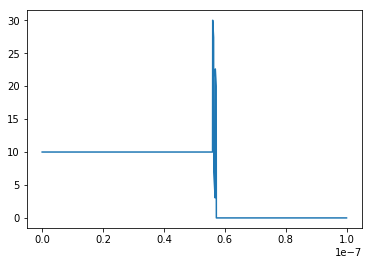

In [65]:
a = 100e-9
m = 9.11e-31
hbar = 1.055e-34
n = 2000

#Manually build double barrier potential
x = np.linspace(0, a, n)
V0 = np.concatenate((np.zeros(1120), 20*np.ones(7), np.zeros(10), 20*np.ones(7), np.zeros(856)))
U0 = 10;
V =  np.concatenate((U0*np.ones(1120), U0*np.linspace(24, 0, 24)/24*np.ones(24), np.zeros(856))) + V0;

#Preview potential
plt.plot(x, V)

In [66]:
#Find eigenfunctions 
E,phi = np.linalg.eigh(hamiltonian(n, V))
gau = np.sqrt(mlab.normpdf(x, 50e-9, 1e-9))/np.sqrt((n-1)/a)*np.exp(5*1j*x/hbar)

c_n = np.conj(gau).dot(phi)
Psi = c_n.dot(phi)

np.size(Psi)

2000

In [67]:
nt = 100
t = np.linspace(0, 2000*1.2496e-17, nt)
z = np.zeros((n,n),      dtype=complex)
Psi_t = np.zeros((nt,n), dtype=complex)

for i in range(nt):
    for j in range(n):
        z[:,j] = c_n[j]*(phi[:,j]*np.exp(-1j*E[j]*t[i]/6.5828E-16))
    Psi_t[i, :] = np.sum(z, 1)

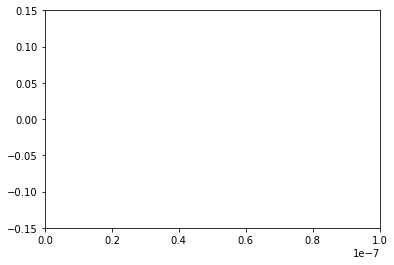

In [71]:
fig, ax = plt.subplots()

ax.set_xlim(0,1e-7)
ax.set_ylim(-0.15, 0.15)

line, = ax.plot([],[], lw=2)

def init():
    line.set_data([],[])
    return line,

def animate(i):
    y = np.real(Psi_t[i,:])
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=50, blit=True)

In [72]:
HTML(anim.to_html5_video())

---
### References
1. [Discretization of 1D Hamiltonian](https://wiki.physics.udel.edu/phys824/Discretization_of_1D_Hamiltonian)
2. [Schrodinger Equation](https://www.wikipedia.com/en/Schr%C3%B6dinger_equation)
3. [Eigenvalues and Eigenfunctions](http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/eigen.html)
4. [A Crash Course in Python for Scientists](http://nbviewer.jupyter.org/gist/rpmuller/5920182)


<span style="color:gray;">Based on projects assigned in University of Waterloo NanoEng Program's Quantum Mechanics course (NE 232 - Instructor/Year: David Corey, 2015). Created as an introduction to using  Python/Jupyter notebooks</span>


